# DGA Detection

In [1]:
# import tools
import pandas as pd
import numpy as np
import tldextract
import warnings

# ignore warning
warnings.simplefilter('ignore')

In [2]:
# extract the domain
def domain_extract(uri):
    ext = tldextract.extract(uri)
    if (not ext.suffix):
        return np.nan
    else:
        return ext.domain

## Legit domains
- [Alexa Top 1 Million - The static 1 million most popular sites by Alexa](http://s3.amazonaws.com/alexa-static/top-1m.csv.zip)

In [3]:
# Alexa Top domain
# https://www.alexa.com/topsites
alexa_df = pd.read_csv('alexa_1M.csv', names=['rank', 'uri'], header=None, encoding='utf-8')

# extract the domain
alexa_df['domain'] = [domain_extract(uri) for uri in alexa_df['uri']]

# delete unnecessary keys
del alexa_df['rank']
del alexa_df['uri']

# drop duplicate and none items
alexa_df = alexa_df.dropna()
alexa_df = alexa_df.drop_duplicates()

# total alexa domains
alexa_total = alexa_df.shape[0]
alexa_total

869020

In [4]:
# set class
alexa_df['class'] = 'legit'
alexa_df.head()

,domain,class
0,google,legit
1,facebook,legit
2,youtube,legit
3,yahoo,legit
4,baidu,legit


## DGA domains
- [Domain feed of known DGA domains from -2 to +3 days](http://osint.bambenekconsulting.com/feeds/dga-feed.txt)
- [Gameover Zeus DGA sample 31000 DGA domains from Dec 2014](https://www.secrepo.com/misc/zeus_dga_domains.txt.zip)
- [data_hacking/dga_detection/data/](https://github.com/SuperCowPowers/data_hacking/tree/master/dga_detection/data)

In [5]:
# DGA domain
dga_df1 = pd.read_csv('dga_domains.txt',names=['raw_domain'], header=None, encoding='utf-8')
dga_df2 = pd.read_csv('zeus_dga_domains.txt',names=['raw_domain'], header=None, encoding='utf-8')
dga_df3 = pd.read_csv('dga-feed.txt',names=['raw_domain', 'description', 'date', 'source'], header=None, encoding='utf-8')

# delete unnecessary keys
del dga_df3['description']
del dga_df3['date']
del dga_df3['source']

# merge dataframes
dga_df = pd.concat([dga_df1, dga_df2, dga_df3])

# extract the domain and convert to lowercase
dga_df['domain'] = dga_df.applymap(lambda x: x.split('.')[0].strip().lower())

# delete key
del dga_df['raw_domain']

# drop duplicate and none items
dga_df = dga_df.dropna()
dga_df = dga_df.drop_duplicates()

# total dga domains
dga_total = dga_df.shape[0]
dga_total

841032

In [6]:
# set class
dga_df['class'] = 'dga'
dga_df.head()

,domain,class
0,04055051be412eea5a61b7da8438be3d,dga
1,1cb8a5f36f,dga
2,30acd347397c34fc273e996b22951002,dga
3,336c986a284e2b3bc0f69f949cb437cb,dga
5,40a43e61e56a5c218cf6c22aca27f7ee,dga


In [7]:
# alexa domain
# split training data and test data
training_alexa, testing_alexa = alexa_df[:round(alexa_total*.9)], alexa_df[round(alexa_total*.9):]
training_alexa.shape[0]

782118

In [8]:
# confirm split is ok
alexa_total == training_alexa.shape[0] + testing_alexa.shape[0]

True

In [9]:
# dga domain
# split training data and test data
training_dga, testing_dga = dga_df[:round(dga_total*.9)], dga_df[round(dga_total*.9):]
training_dga.shape[0]

756929

In [10]:
# again, confirm split is ok
dga_total == training_dga.shape[0] + testing_dga.shape[0]

True

In [11]:
# compact Alexa domain and DGA domain
# ignore the origin index
training_df = pd.concat([training_alexa, training_dga], ignore_index=True)

# shuffle the training data
training_df = training_df.reindex(np.random.permutation(training_df.index))

# total items
training_df.shape[0]

1539047

## Features

In [12]:
# feature 1: length
training_df['length'] = [len(domain) for domain in training_df['domain']]

# select domains > 4
training_df = training_df[training_df['length']>4]

# after selection
training_df.shape[0]

1502402

In [13]:
import math
from collections import Counter

# calculate entropy
# https://en.wikipedia.org/wiki/Entropy_(information_theory)#Definition
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum(count / lns * math.log(count / lns, 2) for count in p.values())

# feature 2: Shannon entropy
training_df['entropy'] = [entropy(domain) for domain in training_df['domain']]
training_df.head()

,domain,class,length,entropy
426315,hofmei,legit,6,2.584963
122384,hibux,legit,5,2.321928
350695,latido,legit,6,2.584963
895059,jm7z614ik6be1advphl7ywxb,dga,24,4.251629
815447,yh26ukwo6j2zt08p00th1qmw,dga,24,3.970176


In [14]:
# calculate the ratio of single letter
def ratio(lst, s, flag=False):
    total = 0
    for v in lst:
        total += s.count(v)
    if False == flag:
        return total/len(s)
    else:
        return (len(s)-total)/len(s)

# feature 3: vowel
training_df['vowel'] = [ratio('aeiou', domain) for domain in training_df['domain']]

# feature 4: consonant
training_df['consonant'] = [ratio('bcdfghjklmnpqrstvwxyz', domain) for domain in training_df['domain']]

# feature 5: number
training_df['num'] = [ratio('0123456789', domain) for domain in training_df['domain']]

# feature 6: non-alphameric
training_df['non-alphameric'] = [ratio('0123456789abcdefghijklmnopqrstuvwxyz', domain, True) for domain in training_df['domain']]

# show some staff
training_df.head()

,domain,class,length,entropy,vowel,consonant,num,non-alphameric
426315,hofmei,legit,6,2.584963,0.500000,0.500000,0.000000,0.0
122384,hibux,legit,5,2.321928,0.400000,0.600000,0.000000,0.0
350695,latido,legit,6,2.584963,0.500000,0.500000,0.000000,0.0
895059,jm7z614ik6be1advphl7ywxb,dga,24,4.251629,0.125000,0.583333,0.291667,0.0
815447,yh26ukwo6j2zt08p00th1qmw,dga,24,3.970176,0.083333,0.541667,0.375000,0.0


In [15]:
# not many domain contains number
training_df[training_df['num']>0].head()

,domain,class,length,entropy,vowel,consonant,num,non-alphameric
895059,jm7z614ik6be1advphl7ywxb,dga,24,4.251629,0.125000,0.583333,0.291667,0.0
815447,yh26ukwo6j2zt08p00th1qmw,dga,24,3.970176,0.083333,0.541667,0.375000,0.0
805085,1w44wli19o7tew1lrtu3t17gwpy8,dga,28,3.851823,0.142857,0.464286,0.392857,0.0
886789,65xrsbqzfqb6xb3vgzovzmi2,dga,24,3.855389,0.083333,0.708333,0.208333,0.0
884339,hq6mmt1471vsr1og5dvf10po9i2,dga,27,4.236369,0.111111,0.481481,0.407407,0.0


In [16]:
# word dictionary
word_df = pd.read_csv('words.txt', names=['word'], header=None, dtype={'word': np.str}, encoding='utf-8')

# cleanup the words and convert to lowercase
word_df = word_df[word_df['word'].map(lambda x: str(x).isalpha())]
word_df = word_df.applymap(lambda x: str(x).strip().lower())

# drop duplicate and none items
word_df = word_df.dropna()
word_df = word_df.drop_duplicates()

# show word dictionary
word_df.head()

,word
37,a
48,aa
51,aaa
53,aaaa
54,aaaaaa


In [17]:
import sklearn.feature_extraction
import operator

# n-gram
# 3/4/5 char gram
# ignore words that appear between 1e-4 ~  1.0
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
alexa_vc = sklearn.feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3, 5), min_df=1e-4, max_df=1.0)

# combination of fit() and transform() api on same data set
# learn the vocabulary dictionary and return term-document matrix
counts_matrix = alexa_vc.fit_transform(alexa_df['domain'])

# sum up the result array to one-dimensional array
# useful log10
# https://www.zhihu.com/question/22012482
alexa_counts = np.log10(counts_matrix.sum(axis=0).getA1())

# n-gram list
ngrams_list = alexa_vc.get_feature_names()

# show the result
alexa_counts

array([2.44870632, 2.18469143, 2.21748394, ..., 2.25527251, 2.20951501,
       2.00432137])

In [18]:
# sort and show
# https://docs.python.org/3.7/library/operator.html#operator.itemgetter
sorted_ngrams = sorted(zip(ngrams_list, alexa_counts), key=operator.itemgetter(1), reverse=True)
print('Alexa NGrams: %d' % len(sorted_ngrams))
for ngram, count in sorted_ngrams[:10]:
    print(ngram, count)

Alexa NGrams: 29106
ing 4.543099108002921
ine 4.409578107288637
ion 4.38172861853511
lin 4.365974421702599
ter 4.359342116772368
ent 4.346939462698991
the 4.292145267814122
and 4.285061975935162
ers 4.248365671612721
tra 4.236360888012924


In [19]:
# n-gram on the dictionary words
# same logic
dict_vc = sklearn.feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3, 5), min_df=1e-5, max_df=1.0)

counts_matrix = dict_vc.fit_transform(word_df['word'])
dict_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = dict_vc.get_feature_names()

# sort iand show
sorted_ngrams = sorted(zip(ngrams_list, dict_counts), key=operator.itemgetter(1), reverse=True)
print('Word NGrams: %d' % len(sorted_ngrams))
for ngram, count in sorted_ngrams[:10]:
    print(ngram, count)

Word NGrams: 123061
ing 4.387300822448285
ess 4.204879333760662
ati 4.1933472563864616
ion 4.165036479994566
ter 4.162415036106447
nes 4.112504458767161
tio 4.076822423342773
ate 4.0723602039634885
ent 4.069631102620343
tion 4.0496056125949735


In [20]:
# document-term matrix
# https://en.wikipedia.org/wiki/Document-term_matrix
# 29106 alexa_grams
alexa_vc.transform(training_df['domain'])

<1502402x29106 sparse matrix of type '<class 'numpy.int64'>'
	with 23176862 stored elements in Compressed Sparse Row format>

In [21]:
# transpose index and columns (one-dimensional array)
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.T.html
alexa_vc.transform(training_df['domain']).T

<29106x1502402 sparse matrix of type '<class 'numpy.int64'>'
	with 23176862 stored elements in Compressed Sparse Column format>

In [22]:
# 1502402 items
alexa_counts * alexa_vc.transform(training_df['domain']).T

array([10.26874401,  8.29743581, 18.7921735 , ..., 33.98514721,
       60.47344197, 61.52463201])

In [23]:
# feature 7: alexa_grams
training_df['alexa_grams'] = alexa_counts * alexa_vc.transform(training_df['domain']).T

# feature 8: word_grams
training_df['word_grams'] = dict_counts * dict_vc.transform(training_df['domain']).T

# show some staff
training_df.head()

,domain,class,length,entropy,vowel,consonant,num,non-alphameric,alexa_grams,word_grams
426315,hofmei,legit,6,2.584963,0.500000,0.500000,0.000000,0.0,10.268744,5.924106
122384,hibux,legit,5,2.321928,0.400000,0.600000,0.000000,0.0,8.297436,6.309940
350695,latido,legit,6,2.584963,0.500000,0.500000,0.000000,0.0,18.792174,20.574445
895059,jm7z614ik6be1advphl7ywxb,dga,24,4.251629,0.125000,0.583333,0.291667,0.0,3.323458,5.019511
815447,yh26ukwo6j2zt08p00th1qmw,dga,24,3.970176,0.083333,0.541667,0.375000,0.0,2.276462,2.025306


In [24]:
# feature 9: difference between alexa_grams and word_grams
# calculate the difference
training_df['diff'] = training_df['alexa_grams'] - training_df['word_grams']
training_df.head()

,domain,class,length,entropy,vowel,consonant,num,non-alphameric,alexa_grams,word_grams,diff
426315,hofmei,legit,6,2.584963,0.500000,0.500000,0.000000,0.0,10.268744,5.924106,4.344638
122384,hibux,legit,5,2.321928,0.400000,0.600000,0.000000,0.0,8.297436,6.309940,1.987496
350695,latido,legit,6,2.584963,0.500000,0.500000,0.000000,0.0,18.792174,20.574445,-1.782272
895059,jm7z614ik6be1advphl7ywxb,dga,24,4.251629,0.125000,0.583333,0.291667,0.0,3.323458,5.019511,-1.696053
815447,yh26ukwo6j2zt08p00th1qmw,dga,24,3.970176,0.083333,0.541667,0.375000,0.0,2.276462,2.025306,0.251156


In [25]:
# show the feature keys
# first two is: domain, class
training_df.keys()[2:]

Index(['length', 'entropy', 'vowel', 'consonant', 'num', 'non-alphameric',
       'alexa_grams', 'word_grams', 'diff'],
      dtype='object')

## Relation between features

In [26]:
import matplotlib.pyplot as plt

# figure settings
plt.rcParams.update({'figure.max_open_warning': 0, 'axes.grid': True, 'figure.figsize':(14.0, 5.0)})

# plot scatter
def scat(legitX, legitY, dgaX, dgaY, labelX, labelY):
    plt.scatter(legitX, legitY, s=120, c='#aaaaff', label='Alexa', alpha=.1)
    plt.scatter(dgaX, dgaY, s=40, c='r', label='DGA', alpha=.3)
    plt.legend()
    plt.xlabel(labelX)
    plt.ylabel(labelY)
    plt.savefig('plots/'+labelX+labelY)

# split Alexa domain and DGA domain
cond = training_df['class'] == 'dga'
dga = training_df[cond]
legit = training_df[~cond]

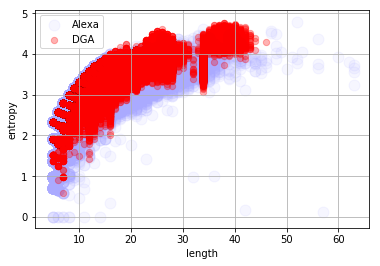

In [27]:
k1, k2 = 'length', 'entropy'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

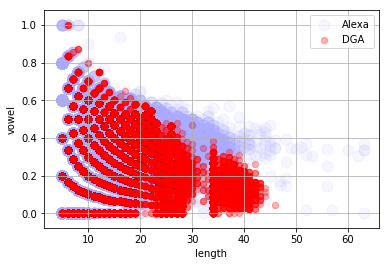

In [28]:
k1, k2 = 'length', 'vowel'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

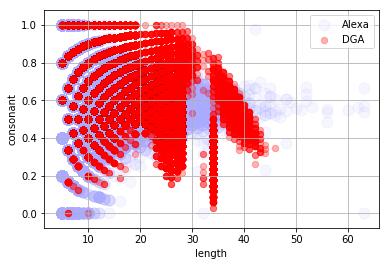

In [29]:
k1, k2 = 'length', 'consonant'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

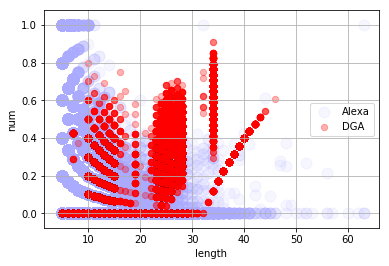

In [30]:
k1, k2 = 'length', 'num'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

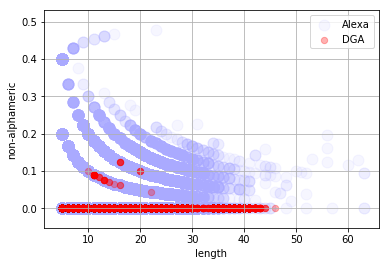

In [31]:
k1, k2 = 'length', 'non-alphameric'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

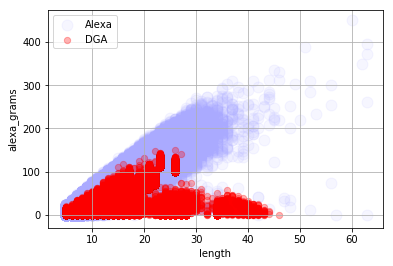

In [32]:
k1, k2 = 'length', 'alexa_grams'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

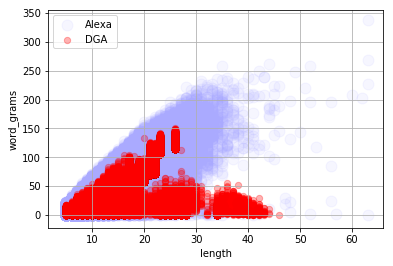

In [33]:
k1, k2 = 'length', 'word_grams'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

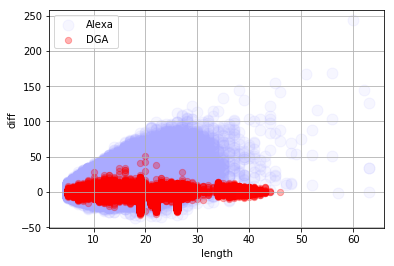

In [34]:
k1, k2 = 'length', 'diff'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

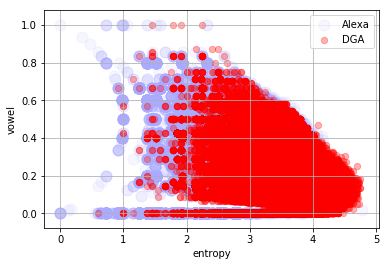

In [35]:
k1, k2 = 'entropy', 'vowel'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

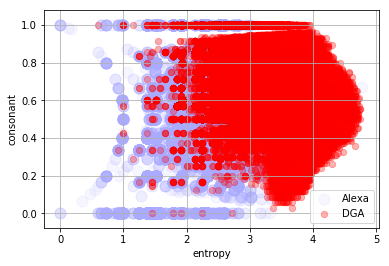

In [36]:
k1, k2 = 'entropy', 'consonant'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

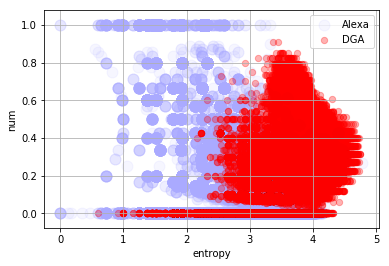

In [37]:
k1, k2 = 'entropy', 'num'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

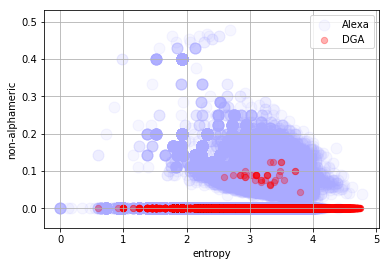

In [38]:
k1, k2 = 'entropy', 'non-alphameric'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

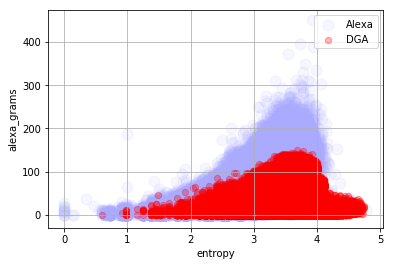

In [39]:
k1, k2 = 'entropy', 'alexa_grams'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

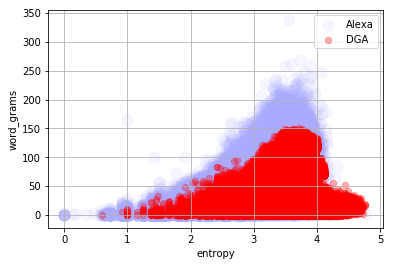

In [40]:
k1, k2 = 'entropy', 'word_grams'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

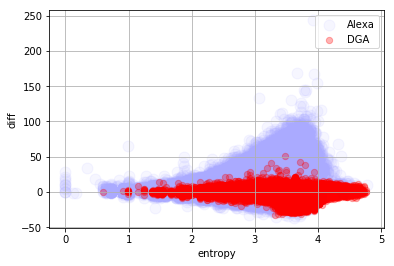

In [41]:
k1, k2 = 'entropy', 'diff'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

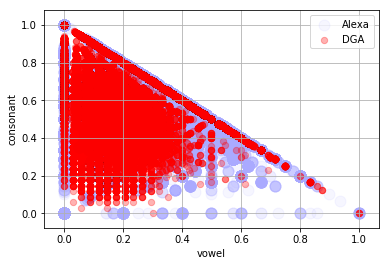

In [42]:
k1, k2 = 'vowel', 'consonant'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

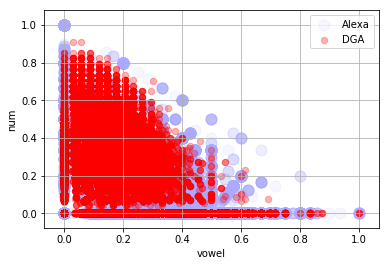

In [43]:
k1, k2 = 'vowel', 'num'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

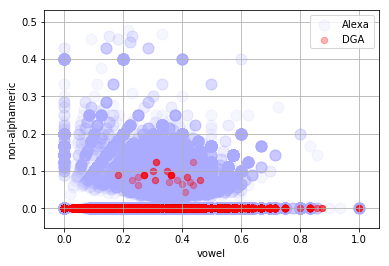

In [44]:
k1, k2 = 'vowel', 'non-alphameric'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

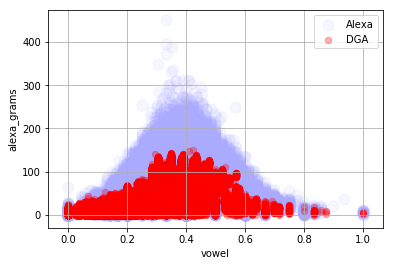

In [45]:
k1, k2 = 'vowel', 'alexa_grams'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

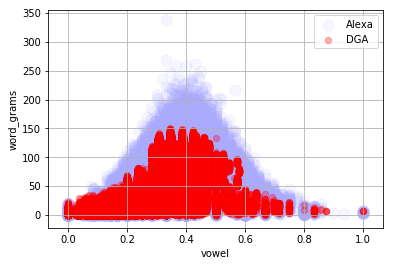

In [46]:
k1, k2 = 'vowel', 'word_grams'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

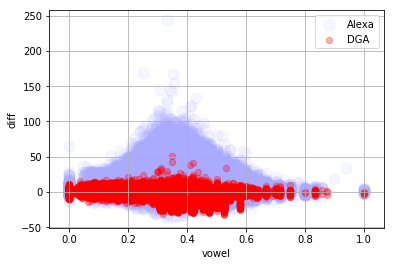

In [47]:
k1, k2 = 'vowel', 'diff'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

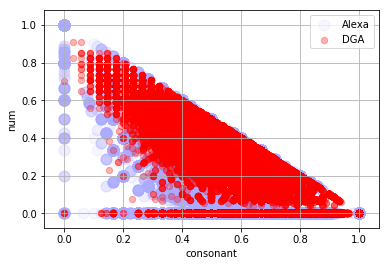

In [48]:
k1, k2 = 'consonant', 'num'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

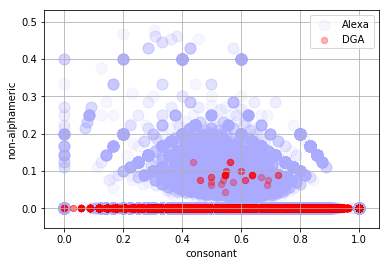

In [49]:
k1, k2 = 'consonant', 'non-alphameric'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

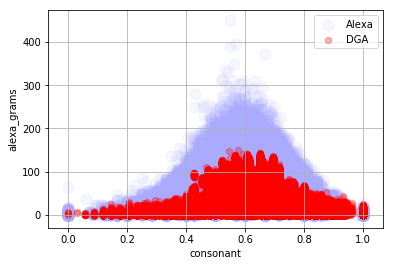

In [50]:
k1, k2 = 'consonant', 'alexa_grams'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

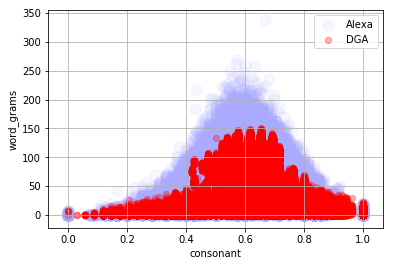

In [51]:
k1, k2 = 'consonant', 'word_grams'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

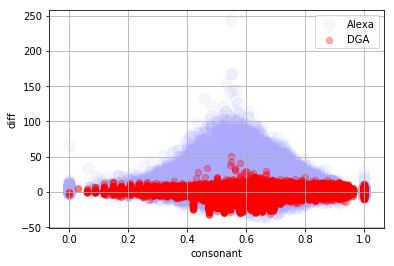

In [52]:
k1, k2 = 'consonant', 'diff'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

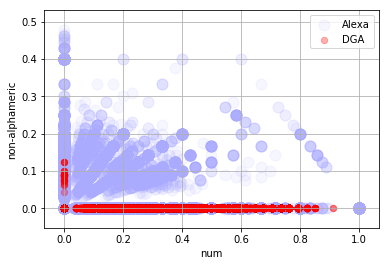

In [53]:
k1, k2 = 'num', 'non-alphameric'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

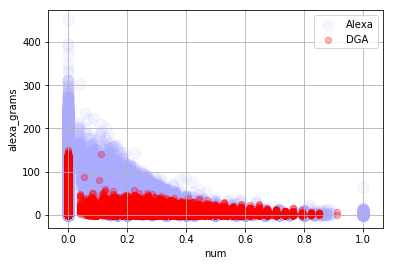

In [54]:
k1, k2 = 'num', 'alexa_grams'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

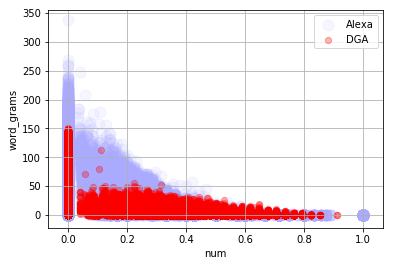

In [55]:
k1, k2 = 'num', 'word_grams'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

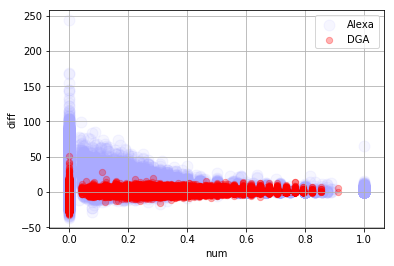

In [56]:
k1, k2 = 'num', 'diff'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

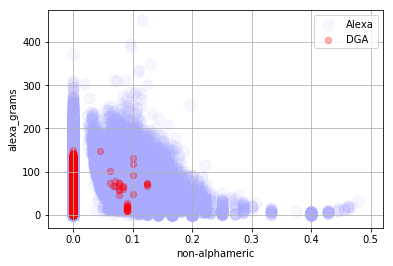

In [57]:
k1, k2 = 'non-alphameric', 'alexa_grams'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

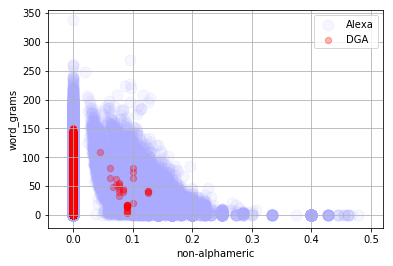

In [58]:
k1, k2 = 'non-alphameric', 'word_grams'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

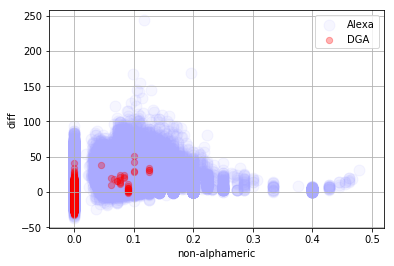

In [59]:
k1, k2 = 'non-alphameric', 'diff'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

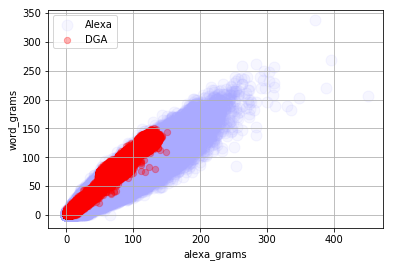

In [60]:
k1, k2 = 'alexa_grams', 'word_grams'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

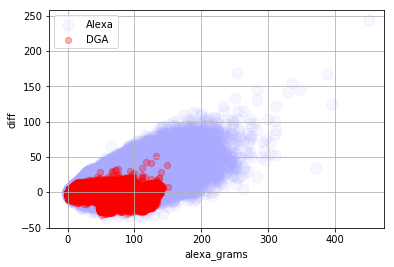

In [61]:
k1, k2 = 'alexa_grams', 'diff'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

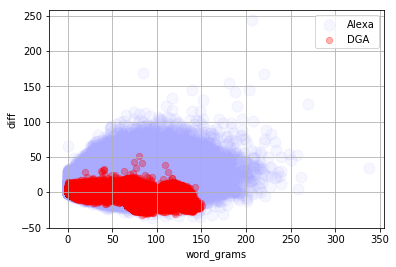

In [62]:
k1, k2 = 'word_grams', 'diff'
scat(legit[k1], legit[k2], dga[k1], dga[k2], k1, k2)

## RandomForest

In [63]:
import sklearn.ensemble

# random forests classifier
# 20 trees
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=20)

# labels: legit, dga
y = np.array(training_df['class'].tolist())

# use for plot
labels = ['legit', 'dga']

In [64]:
# select two features
# convert the frame to numpy-array representation
X = training_df.as_matrix(['entropy', 'diff'])

# evaluate score by cross-validation
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
scores = sklearn.model_selection.cross_val_score(clf, X, y, cv=5, scoring='accuracy')
scores.mean()

0.8758894103555346

### Cross Validation
- [Result](accuracy.md)

In [65]:
from itertools import permutations, combinations

# evaluate score by cross-validation
def cross_score(lst):
    X = training_df.as_matrix(lst)
    scores = sklearn.model_selection.cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    return scores.mean()

# features: length, entropy, vowel, consonant, num, non-alphameric, alexa_grams, word_grams, diff
# traverse and combine features
keys = training_df.keys()[2:]
n = len(keys)

# result = []
# for i in range(1, n+1):
#     for lst in combinations(keys, i):
#         result.append([cross_score(lst), lst])

### Training Result

In [66]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# plot confusion matrix
def plot_cm(cm, labels):
    # compute percentanges
    percent = (cm * 100.0) / np.array(np.matrix(cm.sum(axis=1)).T)

    print('Confusion Matrix Stats')
    for i, label_i in enumerate(labels):
        for j, label_j in enumerate(labels):
            print("%s/%s: %.2f%% (%d/%d)" % (label_i, label_j, (percent[i][j]), cm[i][j], cm[i].sum()))

    # show confusion matrix
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(b=False)
    cax = ax.matshow(percent, cmap='coolwarm')
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print('\n\n')

Confusion Matrix Stats
legit/legit: 96.83% (143970/148689)
legit/dga: 3.17% (4719/148689)
dga/legit: 3.21% (4874/151792)
dga/dga: 96.79% (146918/151792)


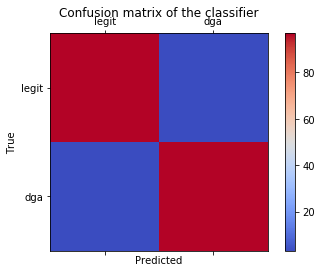

In [67]:
# pick 6 features
X = training_df.as_matrix(['length', 'entropy', 'vowel', 'num', 'alexa_grams', 'diff'])

# split training and testing data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# fit the model
clf.fit(X_train, y_train)

# use model to predict
y_pred = clf.predict(X_test)

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels)
plot_cm(cm, labels)

In [68]:
# show the "weight" of each feature
importances = zip(['length', 'entropy', 'vowel', 'num', 'alexa_grams', 'diff'], clf.feature_importances_)
list(importances)

[('length', 0.2384662069989601),
 ('entropy', 0.19414098125512194),
 ('vowel', 0.07949486545060996),
 ('num', 0.010459411862440258),
 ('alexa_grams', 0.19834829617518795),
 ('diff', 0.27909023825767976)]

Confusion Matrix Stats
legit/legit: 97.00% (144243/148711)
legit/dga: 3.00% (4468/148711)
dga/legit: 3.08% (4679/151770)
dga/dga: 96.92% (147091/151770)


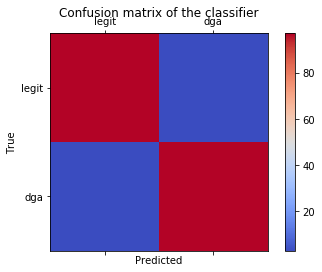

In [69]:
# use 8 features (highest cross-validation score)
max18w = training_df.as_matrix(['length', 'entropy', 'vowel', 'num', 'non-alphameric', 'alexa_grams', 'word_grams', 'diff'])

# split training and testing data 
X_train, X_test, y_train, y_test = train_test_split(max18w, y, test_size=0.2)

# fit the model
clf.fit(X_train, y_train)

# use model to predict
y_pred = clf.predict(X_test)

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels)
plot_cm(cm, labels)

In [70]:
# show the "weight" of each feature
importances = zip(['length', 'entropy', 'vowel', 'num', 'non-alphameric', 'alexa_grams', 'word_grams', 'diff'], clf.feature_importances_)
list(importances)

[('length', 0.19992190269872098),
 ('entropy', 0.21144786553586728),
 ('vowel', 0.09987186128717378),
 ('num', 0.010651808741521492),
 ('non-alphameric', 0.023702723054148396),
 ('alexa_grams', 0.11809980335988557),
 ('word_grams', 0.08399661673814426),
 ('diff', 0.2523074185845381)]

Confusion Matrix Stats
legit/legit: 96.97% (144466/148986)
legit/dga: 3.03% (4520/148986)
dga/legit: 3.08% (4667/151495)
dga/dga: 96.92% (146828/151495)


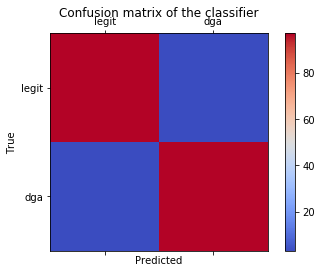

In [71]:
# feature selects (all features)
X = training_df.as_matrix(training_df.keys()[2:])

# train on a 80/20 split
# split into random train and test subsets
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# fit the model
clf.fit(X_train, y_train)

# use the model to predict
y_pred = clf.predict(X_test)

# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels)
plot_cm(cm, labels)

In [72]:
# show the "weight" of each feature
importances = zip(training_df.keys()[2:], clf.feature_importances_)
list(importances)

[('length', 0.2301032062269243),
 ('entropy', 0.21149270349964153),
 ('vowel', 0.044761425561851025),
 ('consonant', 0.0682946496759724),
 ('num', 0.0047585850100837195),
 ('non-alphameric', 0.015216857517994842),
 ('alexa_grams', 0.11999742444277253),
 ('word_grams', 0.06575335701550296),
 ('diff', 0.23962179104925668)]

### Use model to test

In [80]:
# use model to classify
# full features
def test(domain):
    _alexa_match = alexa_counts * alexa_vc.transform([domain]).T
    _dict_match = dict_counts * dict_vc.transform([domain]).T
    _diff = _alexa_match[0] - _dict_match[0]
    _vowel = ratio('aeiou', domain)
    _con = ratio('bcdfghjklmnpqrstvwxyz', domain)
    _num = ratio('0123456789', domain)
    _non = ratio('', domain, True)
    _X = np.array([len(domain), entropy(domain), _alexa_match[0], _dict_match[0], _diff, _vowel, _con, _num, _non])
    return clf.predict([_X])[0]

# test
print(test('google'))
print(test('cuc'))
print(test('smalismalievilsmali'))

### Feature combination
- Not elegant, spend a long time 
- [Result](features.md)

In [75]:
# test all possible feature combination
def fea_test(domains, lst):
    X = training_df.as_matrix(lst)

    # split training and testing data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # fit the model
    clf.fit(X_train, y_train)

    # use model to predict
    y_pred = clf.predict(X_test)
    
    # feature keys
    fkeys = training_df.keys()[2:]
    
    # calculate accuracy
    c = 0
    for index, row in domains.iterrows():
        domain, tag = row['domain'], row['class']
        _len = len(domain)
        _entropy = entropy(domain)
        _vowel = ratio('aeiou', domain)
        _con = ratio('bcdfghjklmnpqrstvwxyz', domain)
        _num = ratio('0123456789', domain)
        _non = ratio('', domain, True)
        _alexa_match = alexa_counts * alexa_vc.transform([domain]).T
        _dict_match = dict_counts * dict_vc.transform([domain]).T
        _diff = _alexa_match[0] - _dict_match[0]
        f = dict(zip(fkeys, [_len, _entropy, _vowel, _con, _num, _non, _alexa_match[0], _dict_match[0], _diff]))
        _X = np.array([f.get(key) for key in lst])
        if tag != clf.predict([_X])[0]:
            c += 1
    print(c/len(domains), lst)

## Test domain
- [DDS legit and DGA labeled domains - DDS Blog](http://datadrivensecurity.info/blog/data/2014/10/legit-dga_domains.csv.zip)

In [76]:
# host, domain, class, subclass
test_df = pd.read_csv('legit-dga_domains.csv', header=0, encoding='utf-8')
test_df.head()

,host,domain,class,subclass
0,000directory.com.ar,000directory,legit,legit
1,000webhost.com,000webhost,legit,legit
2,001fans.com,001fans,legit,legit
3,01-telecharger.com,01-telecharger,legit,legit
4,010shangpu.com,010shangpu,legit,legit


In [77]:
del test_df['host']
del test_df['subclass']

tot = test_df.shape[0]
tot

133926

In [78]:
# shuffle the test data
test_df = test_df.reindex(np.random.permutation(test_df.index))
test_df.head()

,domain,class
8044,aamulehti,legit
83689,odoovbobquefiy,dga
64882,kiru2ch,legit
42469,flashback,legit
19488,bolalist,legit


In [81]:
c = 0
for index, row in test_df.iterrows():
    if test(row['domain']) != row['class']:
        c += 1
c/tot

0.4649731941519944

In [ ]:
temp_df = training_df[:52402]
temp_df.head()

In [ ]:
# # features: length, entropy, vowel, consonant, num, non-alphameric, alexa_grams, word_grams, diff
# # traverse and combine features
# keys = training_df.keys()[2:]
# n = len(keys)

# for i in range(1, n+1):
#     for lst in combinations(keys, i):
#         fea_test(temp_df, lst)

In [83]:
# test feature
X = training_df.as_matrix(['length', 'entropy', 'vowel', 'num', 'alexa_grams', 'diff'])

# split training and testing data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# fit the model
clf.fit(X_train, y_train)

# use model to predict
y_pred = clf.predict(X_test)

In [87]:
y_pred

array(['legit', 'dga', 'legit', ..., 'legit', 'legit', 'dga'], dtype='<U5')

In [88]:
y_test

array(['legit', 'dga', 'legit', ..., 'legit', 'legit', 'dga'], dtype='<U5')

Confusion Matrix Stats
legit/legit: 96.82% (144723/149477)
legit/dga: 3.18% (4754/149477)
dga/legit: 3.21% (4848/151004)
dga/dga: 96.79% (146156/151004)


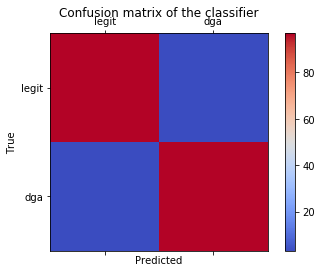

In [91]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels)
plot_cm(cm, labels)

## Result
### Error Rate
- 133926 test domains
- Work better with `['length', 'entropy', 'vowel', 'consonant', 'alexa_grams', 'word_grams', 'diff']`

In [92]:
fea_test(test_df, ['length', 'entropy', 'vowel', 'num', 'alexa_grams', 'diff'])

0.007974553111419739 ['length', 'entropy', 'vowel', 'num', 'alexa_grams', 'diff']


In [93]:
fea_test(test_df, ['length', 'entropy', 'consonant', 'num', 'alexa_grams', 'word_grams', 'diff'])

0.007324940638860266 ['length', 'entropy', 'consonant', 'num', 'alexa_grams', 'word_grams', 'diff']


In [94]:
fea_test(test_df, ['entropy', 'vowel', 'consonant', 'alexa_grams', 'word_grams'])

0.0077654824305960005 ['entropy', 'vowel', 'consonant', 'alexa_grams', 'word_grams']


In [95]:
fea_test(test_df, ['length', 'entropy', 'vowel', 'consonant', 'alexa_grams', 'word_grams', 'diff'])

0.0072353389185072356 ['length', 'entropy', 'vowel', 'consonant', 'alexa_grams', 'word_grams', 'diff']


In [96]:
fea_test(test_df, ['length', 'entropy', 'vowel', 'consonant', 'num', 'alexa_grams', 'word_grams', 'diff'])

0.007399608739154458 ['length', 'entropy', 'vowel', 'consonant', 'num', 'alexa_grams', 'word_grams', 'diff']
